# Hyperparameter Tuning: Learning Rate and Metrics

Welcome to this first exploration of hyperparameter tuning using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset!  This dataset consists on 60,000 32x32 color images in 10 classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each: 

![](./nb_image/cifar10.png)

In this notebook, you'll focus specifically on the learning rate, an essential hyperparameter that dictates the pace at which a model learns during training. You'll work with a simple convolutional neural network (CNN) and observe how changes in hyperparameters affect the model's outcomes.

This lab will cover the following:

* Examining the effects of different **learning rates** on model performance.

* Introducing and using additional metrics like **precision, recall, and F1 score** for a more complete evaluation.

* Exploring the effect of **batch size** on different metrics using an imbalanced dataset in an optional section.

In [8]:
import pandas as pd 
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics

import helper

helper.set_seed(42)

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


## Learning Rate Optimization on CIFAR-10

You will now explore how the learning rate affects the performance of a simple convolutional neural network (CNN) on the CIFAR-10 dataset.
For that you will train a simple CNN model with different learning rates and observe the validation accuracy to understand the sensitivity of the model to this hyperparameter.

The code below sets up the necessary functions for training the model and evaluating its performance:

- `SimpleCNN`: defines a small convolutional neural network architecture.

- `evaluate_accuracy`: computes the accuracy on a validation dataset.

These functions encapsulate the key elements required for running the hyperparameter optimization experiments.

In [21]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """

    def __init__(self):
        """Initialize the layers of the neural network."""

        #Initialize the parent nn.Module class
        super().__init__()

        #First convolution layer (3 input channels, 16 output channels , 3X3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        #Second con layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        #Max pooling layer with 2X2 windows and stride of 2
        self.pool = nn.MaxPool2d(2,2)

        #First fully connected liner layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)

        #Second fully connected lauer serving as a output layer
        self.fc2 = nn.Linear(64, 10)

        #Dropout layer for regularization
        self.droput = nn.Dropout(p=0.4)

    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """

        #Apply first convolution, ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        #Apply second convolution, ReLU activation, and max poling
        x = self.pool(F.relu(self.conv2(x)))

        #Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32*8*8)

        #Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        #Apply dropout for regulatization
        x = self.droput(x)

        #Apply the final outputlayer
        x = self.fc2(x)

        return x

def evaluate_accuracy(model, val_loader, device):
    """Calculates the accuracy of a model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to be evaluated.
        val_loader (DataLoader): The DataLoader containing the validation or test data.
        device: The device (e.g., 'cuda' or 'cpu') to perform the evaluation on.

    Returns:
        float: The computed accuracy of the model on the dataset.
    """

    #Set the model for evaluation mode
    model.eval()

    #Initialize the counter for accuracy calculation
    total_correct = 0
    total_sample = 0

    #Disable gradient computation for evaluation
    with torch.no_grad():
        #Iterate over the data in provided laoder
        for inputs, labels in val_loader:
            #move inputs and label to specific device
            inputs, labels = inputs.to(device), labels.to(device)

            #Perform a forward pass to get the model output
            outputs = model(inputs)

            #Get the predicted class by finding the index of maximun logit
            _, predicted = outputs.max(1)

            #Update the cound of correctly classified samples 
            total_correct +=(predicted == labels).sum().item()

            #Update the total number of samiles processed
            total_sample += labels.size(0)

    #Calculate the final accuracy 
    accuracy =total_correct / total_sample

    return accuracy

In the code below, the `train_and_evaluate` function:

- defines the model  
- sets up the optimizer with a specified learning rate and defines the loss function  
- prepares the train and validation dataloaders  
- trains the model for a specified number of epochs  
- evaluates the model's performance on the validation set

The functions `get_dataset_dataloaders` and `train_model` are imported from `helper_utils` and handle dataset preparation and model training, respectively.

In [22]:
def train_and_evaluate(learning_rate, device,n_epochs=25, batch_size=128):
    """Trains and evaluates a model for a specific learning rate and configuration.

    This function orchestrates the entire workflow: it sets a random seed,
    initializes the model, optimizer, and dataloaders, trains the model,
    and finally evaluates its accuracy on a validation set.

    Args:
        learning_rate (float): The learning rate to use for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of epochs for training. Defaults to 25.
        batch_size (int, optional): The batch size for the dataloaders. Defaults to 128.

    Returns:
        float: The final validation accuracy of the trained model.
    """

    #Set the random seeds for reproducibility
    helper.set_seed(42)

    #Initialize the CNN model and move it to specific device
    model = SimpleCNN().to(device)

    #Define the loss function
    loss_fcn = nn.CrossEntropyLoss()

    #Define the optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #Prepare the training and validtion dataloader
    train_dataloader, val_dataloader = helper.get_dataset_dataloaders(batch_size=batch_size)

    #Call the main training loop to train the model 
    helper.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs)

    #Evaluate the trained model's accuracy on the validaton set
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    print(f"Leaning rate: {learning_rate}, Accuracy: {accuracy:.4f}")

    return accuracy

A few different learning rates are used from a low ($10^{-5}$) to a high value ($10^{-1}$).

For each learning rate, the model is trained for **25 epochs** with a **batch size of 128**.
After training, the model is evaluated on the validation set to compute the validation accuracy. 

In [23]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1] #Low to high
accuracies = []

for lr in learning_rates:
    acc = train_and_evaluate(learning_rate=lr, device=device)
    accuracies.append(acc)

Current Epoch:   0%|          | 0/25 [00:24<?, ?it/s]


Training completed
Leaning rate: 1e-05, Accuracy: 0.3220


Current Epoch:   0%|          | 0/25 [00:24<?, ?it/s]


Training completed
Leaning rate: 0.0001, Accuracy: 0.4865


Current Epoch:   0%|          | 0/25 [00:24<?, ?it/s]


Training completed
Leaning rate: 0.001, Accuracy: 0.5820


Current Epoch:   0%|          | 0/25 [00:24<?, ?it/s]


Training completed
Leaning rate: 0.01, Accuracy: 0.4800


Current Epoch:   0%|          | 0/25 [00:24<?, ?it/s]


Training completed
Leaning rate: 0.1, Accuracy: 0.1005


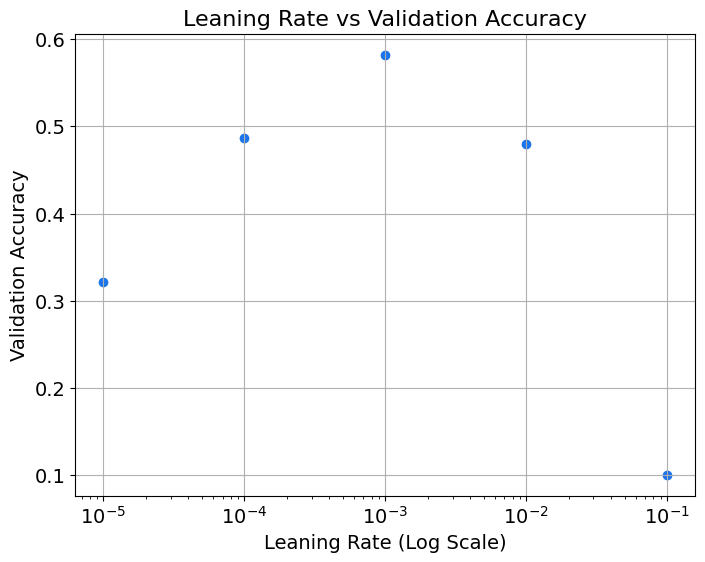

In [24]:
helper.plot_results(learning_rates, accuracies)

<br>

The plot shows that the learning rate of 0.001 provides the highest validation accuracy, indicating it is the **optimal choice** between the tested values.

Smaller learning rates leads to slower learning and lower accuracy, suggesting that the optimizer will take a long time to converge. 
Larger learning rates results in unstable training and lower accuracy.

## Other relevant metrics: Recall, Precision, and F1 Score

Deep learning models are typically trained by optimizing a *loss function*, such as **cross-entropy loss**. 
This loss quantifies the difference between the predicted probabilities and the true labels, guiding the model to adjust its parameters.
It provides a scalar loss that can be minimized using gradient-based optimization algorithms.

However, the loss function optimized during training does not always align with the **evaluation metrics** you care about in practice. Metrics like **accuracy**, **precision**, **recall**, and **F1 score** offer a more nuanced understanding of model performance.

-  **Accuracy**: The ratio of correct predictions to the total number of predictions. 
But it can be misleading in **imbalanced datasets**, where the model may achieve high accuracy simply by predicting the majority class.

- **Precision and Recall**:
These metrics evaluate performance on a **per-class** basis, offering better insight into class-specific behaviors.
For each class $k$:
  $$
  \text{Precision}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}
  $$
  $$
  \text{Recall}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}
  $$

  Where:
  - **TPₖ** (True Positives): Correct predictions for class $k$.
  - **FPₖ** (False Positives): Instances incorrectly predicted as class $k$.
  - **FNₖ** (False Negatives): Instances truly belonging to class $k$ but predicted as another class.
  >
  
  To evaluate overall performance in a multiclass setting, these metrics can be aggregated:

  - **Macro-average**:
    Averages metrics across classes, treating all classes equally. *Useful when class balance is important.*
      - This is often used for **Precision, Recall, and F1** to prevent the majority class from dominating the score.
  >
  - **Micro-average**:
    Computes metrics globally by aggregating all TP, FP, and FN. *Useful when class sizes vary significantly.*
    - *Standard Accuracy* is calculated using this method (Total Correct / Total Samples).
  >  
  - **Weighted-average**:
    Averages metrics across classes, weighted by the number of true instances per class. *Balances influence of both major and minor classes.*
    - Use this when you want a metric that reflects the **true data distribution**, ensuring that performance on common classes contributes proportionately more to the final score than rare classes.
  >

- **F1 Score**:
  It combines precision and recall into a single number, useful when both false positives and false negatives are important:
  $$
  \text{F1}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
  $$
  Like precision and recall, it can be aggregated (macro, micro, weighted) depending on the evaluation goal.

All these metrics range from 0 to 1, where higher values indicate better performance. The goal is to maximize each metric.

Some use cases for these metrics include:

- **Precision** is essential when **false positives** are costly (e.g., spam detection, medical diagnosis).
- **Recall** is vital when **false negatives** are costly (e.g., disease screening, fraud detection).
- **F1 score** is ideal when both false positives and false negatives matter, as it provides a trade-off between the two.

## Exercise: Implementing Metrics in PyTorch

The following function `evaluate_metrics` is designed to evaluate a model's performance on a validation dataset using various metrics such as accuracy, precision, recall, and F1 score.

Your exercise is to complete the `evaluate_metrics` function, which calculates key performance metrics for a model using the `torchmetrics` library.

**Your Task**:

* **Initialize the metrics**:
    * In the first code block, create instances for **precision, recall, and F1 score** using the corresponding classes from `torchmetrics`.
    * For each metric, ensure you set the parameters correctly: `task="multiclass"`, `num_classes=num_classes`, and `average="macro"`.
        * **Note**: The `accuracy_metric` is already initialized for you with `average="micro"` (standard accuracy).
>
* **Update the metrics in the loop**:
    * Within the second code block, inside the `for` loop, you must update each metric with the results from the current batch.
    * Call the `.update()` method on your `precision_metric`, `recall_metric`, and `f1_metric` objects, passing in the predicted values and the true labels.
>
* **Compute the final scores**:
    * In the final code block, after the evaluation loop is complete, compute the final value for each metric.
    * Call the `.compute()` method for each metric and then use `.item()` to get the final scalar result to assign to the `precision`, `recall`, and `f1` variables.